# QBoost with D-Wave's Annealer

QBoost was implemented using D-Wave’s real quantum annealer, Advantage_system4.1 was used. To run this notebook, one need to create account on D-Wave's [Leap](https://cloud.dwavesys.com/leap) service and paste the API token below.

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
os.environ['DWAVE_API_TOKEN'] = 'TOKEN'

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay, roc_curve
import seaborn as sns
from sklearn.manifold import TSNE
from jax_utils import square_kernel_matrix_jax, kernel_matrix_jax, target_alignment_jax
from dwave.samplers import SimulatedAnnealingSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from qboost import QBoostClassifier
import pennylane.numpy as pnp
import pennylane as qml

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import jax
import jax.numpy as jnp
import optax

jax.config.update("jax_enable_x64", True)

seed = 42
np.random.seed(42)

np.random.seed(seed)
pnp.random.seed(seed)

jax.devices()


[CpuDevice(id=0)]

In [14]:
df = pd.read_csv("weather/weather-010824-061024.csv")
df.shape

(1658, 12)

In [15]:
def weather_map(x):
    val = int(x / 100)
    if val == 5:
        return 1
    return 0


df["is_rain"] = df.cod_weather.apply(weather_map)

In [16]:
features = [
    "hum",
    "pres",
    "rain_1h",
    # "wind_speed",
    # "wind_deg",
    # "clouds_all",
    # "max_temp",
    # "min_temp",
    # "ave_temp",
]
target = "is_rain"

We split the saved train data to train and validation datasets. We also change the labels from 0, 1 to -1, 1 because we will be using Pauli-Z observable in the Quantum Circuit whose eigenvalues are -1, 1. Therefore, a 1 means that the stock price is manipulated.

In [17]:
X = df[features].to_numpy()
y = 2 * df[target].to_numpy() - 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)
X_train.shape, X_test.shape

((1160, 3), (498, 3))

In [18]:
sum(y_train == 1), sum(y_test == 1)

(23, 10)

<Axes: >

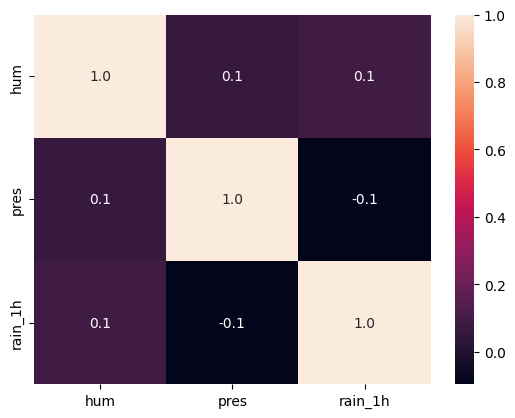

In [19]:
sns.heatmap(df[features].corr('spearman'), annot=True, fmt=".1f")

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mm_scaler = MinMaxScaler((-1, 1))
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

X_train.shape, X_test.shape

((1160, 3), (498, 3))

## Baseline

In [21]:
sampler_params = {
    'num_reads': 2000
}
num_weak_classifiers = 50
tree_depth = 2
lmd = 1.5
dwave_sampler = DWaveSampler()
emb_sampler = EmbeddingComposite(dwave_sampler)

In [22]:
model_name = 'qboost'
base_model = QBoostClassifier(n_estimators=num_weak_classifiers, max_depth=tree_depth)
base_model.fit(X_train, y_train, emb_sampler, lmd=lmd, print_bqm_info=True, **sampler_params)

BQM info:
Num variables: 50
Num interactions: 1225


In [23]:
y_preds = base_model.predict(X_train)
print(sum(y_preds == 1), sum(y_preds == -1))
print(classification_report(y_train, y_preds))

19 1141
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1137
           1       1.00      0.83      0.90        23

    accuracy                           1.00      1160
   macro avg       1.00      0.91      0.95      1160
weighted avg       1.00      1.00      1.00      1160



In [24]:
y_pred = base_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

baseline_Recall = recall_score(y_test, y_pred)
baseline_Precision = precision_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)
baseline_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[484   4]
 [  4   6]]


In [25]:
ndf = [(baseline_Recall, baseline_Precision, baseline_f1, baseline_accuracy)]

baseline_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
baseline_score.insert(0, f"{model_name} with", "Baseline")
baseline_score

,qboost with,Recall,Precision,F1 Score,Accuracy
0,Baseline,0.6,0.6,0.6,0.983936


## Random oversampling

In [26]:
ro_model = QBoostClassifier(n_estimators=num_weak_classifiers, max_depth=tree_depth)

In [27]:
X_over, y_over = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
X_over.shape, sum(y_over == 1), sum(y_over == -1)

((2274, 3), 1137, 1137)

In [28]:
ro_model.fit(X_over, y_over, emb_sampler, lmd, **sampler_params)
y_pred = ro_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

over_Recall = recall_score(y_test, y_pred)
over_Precision = precision_score(y_test, y_pred)
over_f1 = f1_score(y_test, y_pred)
over_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[484   4]
 [  2   8]]


In [29]:
ndf = [(over_Recall, over_Precision, over_f1, over_accuracy)]

over_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_score.insert(0, f'{model_name} with', 'Random Oversampling')
over_score

,qboost with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.8,0.666667,0.727273,0.987952


## Smote Tomek

In [30]:
smote_tomek_model = QBoostClassifier(n_estimators=num_weak_classifiers, max_depth=tree_depth)

In [31]:
X_smote, y_smote = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority")).fit_resample(X_train, y_train)
X_smote.shape, sum(y_smote == 1), sum(y_smote == -1)

((2274, 3), 1137, 1137)

In [32]:
smote_tomek_model.fit(X_smote, y_smote, emb_sampler, lmd, **sampler_params)
y_pred = smote_tomek_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

SMOTETomek_Recall = recall_score(y_test, y_pred)
SMOTETomek_Precision = precision_score(y_test, y_pred)
SMOTETomek_f1 = f1_score(y_test, y_pred)
SMOTETomek_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[480   8]
 [  0  10]]


In [33]:
ndf = [
    (
        SMOTETomek_Recall,
        SMOTETomek_Precision,
        SMOTETomek_f1,
        SMOTETomek_accuracy,
    )
]

SMOTETomek_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
SMOTETomek_score.insert(0, f'{model_name} with', "SMOTE + Tomek")
SMOTETomek_score

,qboost with,Recall,Precision,F1 Score,Accuracy
0,SMOTE + Tomek,1.0,0.555556,0.714286,0.983936


In [34]:
predictions = pd.concat(
    [baseline_score, over_score, SMOTETomek_score], ignore_index=True, sort=False
)
predictions.sort_values(by=["Recall"], ascending=False)

,qboost with,Recall,Precision,F1 Score,Accuracy
2,SMOTE + Tomek,1.0,0.555556,0.714286,0.983936
1,Random Oversampling,0.8,0.666667,0.727273,0.987952
0,Baseline,0.6,0.600000,0.600000,0.983936


In [35]:
predictions.to_csv('results/qboost_dwave.csv')

## Summary

- The Smote Tomek model proved highly effective in detecting all rain events, though at the cost of some false positives, making it suitable for applications prioritizing recall.
- Random oversampling model offered a balanced performance for both classes and minimizing the risk of false positives while maintaining high recall.

## ROC-AUC curve

In [36]:
y_pred = ro_model.predict(X_test)
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for SVC with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for SVC with Class weights: 0.8959


In [37]:
y_pred = smote_tomek_model.predict(X_test)
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for SVC with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for SVC with Class weights: 0.9918
